## Intramolecular Potential Energy Surfaces

### Overview

In this exercise we create a scan of the rotation of the nitro group in nitrobenzene to obtain a dihedral potential energy plot. These types of plots help us to understand how easily functional groups can change their molecular configuration.

### Initial molecule specification

We will use the optimized nitrobenzene molecule from the geometry optimization lesson. If you remember, one of the tasks in the last exercise was to print out the final geometry from the optimization into a file names molecule_name_geometry_final.dat where molecule_name was the name of the molecular system we were interested in (benzene or nitrobenzene). You will need to find and open this file for nitrobenzene to get the coordinates of the optimized structure for this exercise.

### Understanding the internal coordinates of nitrobenzene

Before we can set up the calculations to rotate the nitro group in nitrobenzene, we need to understand which atoms are involved in each internal coordinate for benzene. One way to do this is to, look at the optimized molecule in a molecular visualization program like Avogadro. Most molecular visualization programs use a few standard file formats to specify the geometry of the molecule. One of the most simple of these file formats is the xyz file.

The standard format of an xyz file is to have the number of atoms on the first line, a comment line for the second line and then the element name and x, y, and z coordinates (each on separate lines). An example of this type of file for water would be:  
```
3
Water geometry
O  0.000 0.000 0.000
H  0.757 0.586 0.000
H -0.757 0.586 0.000
```

## Calculating the rotational Potential Energy Surface

Our goal in this exercise is to understand the way the energy of the molecule changes as we rotate the nitro group relative to the benzyl group. We could just rotate the nitro group a certain number of degrees, calculate an energy, and then repeat as many times as we need to get a decent looking plot. However, one problem with this is that the bond lengths, and perhaps other angles not associated with the rotation, may actually want to change to get to a lower energy. The best way to make sure that we are getting the lowest energy associated with the rotation is to rotate the molecule, freeze the dihedrals, and then optimize the geometry - letting all other coordinates change except the frozen dihedrals. This is called a **constrained optimization**.


### Setting up the molecule and getting the initial energy

The first code block will set up our molecule as an object in Psi4 using the function `psi4.geometry`. You will need to add in the final coordinates of your molecule from the nitrobenzene optimization from the last exercises. As before, we can use Psi4 to calculate different attributes of the molecule using the basis set that we specify. In this case we will use the Hartree-Fock method (SCF) and the cc-pVDZ basis set to calculate the energy of the molecule and store it in a value E for printing in the notebook when the calculation is complete. It is useful to check to make sure that this energy is the same as the one from the final geometry in the optimization - just to make sure that the geometry that you have put in is OK.

We can also print the positions of all the atoms at any time using `molecule.print_out_in_angstrom()` and all of the interatomic distances using `molecule.print_distances()`. We will print these to a file called ‘geometry_initial’ just as an example, but we don’t really need this information right now.

In [1]:
from rdkit.Chem import AllChem as Chem
nitrobenzene = Chem.MolFromSmiles('c1ccc(cc1)[N+](=O)[O-]')
nitrobenzene = Chem.AddHs(nitrobenzene)
nitrobenzene.SetProp('_Name', '0 1')
Chem.EmbedMolecule(nitrobenzene)
nitrobenzene_geometry = Chem.MolToXYZBlock(nitrobenzene)
print(nitrobenzene_geometry)

14
0 1
C     -1.921605   -0.062260    0.129548
C     -1.251342    1.137864    0.011455
C      0.139151    1.197371   -0.083180
C      0.873898    0.030496   -0.059048
C      0.190697   -1.159068    0.059237
C     -1.188946   -1.228411    0.153771
N      2.300453    0.033873   -0.152576
O      2.963124   -1.020232   -0.130710
O      3.007246    1.204612   -0.271241
H     -3.016780   -0.096216    0.203293
H     -1.819900    2.056247   -0.008167
H      0.675349    2.128938   -0.175893
H      0.775093   -2.064586    0.077036
H     -1.726438   -2.158629    0.246474



In [2]:
nitrobenzene_geometry = nitrobenzene_geometry.replace('14\n', 'symmetry c1\n')
print(nitrobenzene_geometry)

symmetry c1
0 1
C     -1.921605   -0.062260    0.129548
C     -1.251342    1.137864    0.011455
C      0.139151    1.197371   -0.083180
C      0.873898    0.030496   -0.059048
C      0.190697   -1.159068    0.059237
C     -1.188946   -1.228411    0.153771
N      2.300453    0.033873   -0.152576
O      2.963124   -1.020232   -0.130710
O      3.007246    1.204612   -0.271241
H     -3.016780   -0.096216    0.203293
H     -1.819900    2.056247   -0.008167
H      0.675349    2.128938   -0.175893
H      0.775093   -2.064586    0.077036
H     -1.726438   -2.158629    0.246474



In [4]:
# Start working with psi4

import psi4
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
psi4.set_memory('2 GB')
psi4.set_num_threads(4)

molecule_name = "nitrobenzenepes"
molecule = psi4.geometry(nitrobenzene_geometry)

psi4.set_output_file(molecule_name + '_energy_initial.dat', False)
E = psi4.energy('scf/cc-pVDZ')

psi4.set_output_file(molecule_name + '_geometry_initial.dat', False)
molecule.print_out_in_angstrom()
molecule.print_distances()

print('The energy is: ', E)

The energy is:  -434.16277405136617


### Determine the dihedral to be rotated and set up the angles to do the calculation

Now that we have the molecule setup, we need to decide which dihedrals needs to be rotated and then set up an array with the angles that we want to do the calculations. The definition of a dihedral angle is the angle between two planes. We know that three points define a plane, so to specify a dihedral angle, you specify four atom numbers. The first three numbers define the first plane and the last three numbers define the second plane. The two middle numbers are used in both plane definitions.

We want to rotate the nitro group around the plane of benzene. The first three numbers will be the atoms that form the nitro group: one of the oxygens, the nitrogen, and the carbon the nitrogen is attached to. The second three numbers will define the plane of the benzene ring: the nitrogen, the carbon the nitrogen is attached to, and an adjacent carbon in the aromatic ring. There are two oxygens in the nitro group, so we will define two dihedral angles, one based on each, `dihedral1` and `dihedral2`.

### Exercise

Determine the atom numbers for the atoms involved in `dihedral1` and `dihedral2`. Both dihedrals should be defined such that their initial value is zero.

In [6]:
def draw_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx() + 1)
    return mol

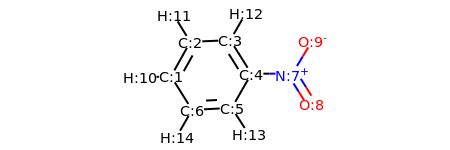

In [7]:
draw_with_atom_index(nitrobenzene)

In [8]:
# set the dihedrals to be rotated around
dihedral1 = "3 4 7 8"
dihedral2 = "5 4 7 9"

One of the challenges of computations like this is to make sure that the number of calculations is reasonable to give a smooth potential energy plot. For different molecules, you may have to use a different step size for your angle rotation. But if you choose too big of a step size, the optimization may fail. If you take too small of a step, then it will take a long time to generate the calculations. In this example, we will initially rotate our dihedral angle by increments of 10 degrees. We will have these values into a numpy array called `phi`.

In [ ]:
# set the values of the dihedral for the calculations
# note that each value will correspond to a geometry optimization
# 